# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tqdm import tqdm

# Introduction to Deep Learning in Python using TensorFlow and Keras

In this section, we are going to explore the tensorflow package by creating a neural network to determine hand written numbers. We will be using the MNIST data set. This is example is like the "hello world" of deep learning. This activity should help us get familiar with deep learning and how we can apply it to our current project. This example will be using a convolutional neural network (CNN). For our project for predicting games, we will use a multilayer perceptron.

In [2]:
import tensorflow as tf

# Get 28x28 images of handwritten digits 0-9
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) =  mnist.load_data()

# Normalize our data
X_train = tf.keras.utils.normalize(X_train)
X_test = tf.keras.utils.normalize(X_test)

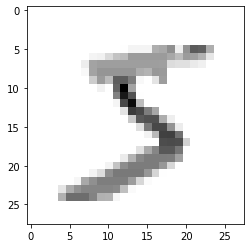

In [3]:
import matplotlib.pyplot as plt

# Show the first image in our training set
plt.imshow(X_train[0], cmap = plt.cm.binary)

plt.show()

In [4]:
# Build the model
model = tf.keras.models.Sequential()

# Add our input layer
model.add(tf.keras.layers.Flatten())

# Add a hidden layers
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))

# Add output layer
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 2s 986us/step - loss: 0.4754 - accuracy: 0.8623
Epoch 2/3
1875/1875 [==============================] - 2s 927us/step - loss: 0.1127 - accuracy: 0.9657
Epoch 3/3
1875/1875 [==============================] - 2s 807us/step - loss: 0.0740 - accuracy: 0.9767


In [5]:
validation_loss, validation_accuracy = model.evaluate(X_test, y_test)
print(f"Validation loss: {validation_loss}")
print(f"Validation accuracy: {validation_accuracy}")

313/313 [==============================] - 0s 658us/step - loss: 0.0791 - accuracy: 0.9749
Validation loss: 0.07908321171998978
Validation accuracy: 0.9749000072479248


Consider rewriting this model with the Functional API.
The model's prediction: 7


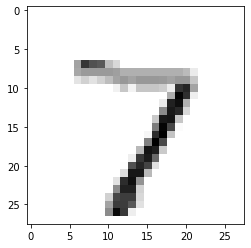

In [6]:
import numpy as np

predictions = model.predict([X_test])
print(f"The model's prediction: {np.argmax(predictions[0])}")

plt.imshow(X_test[0], cmap = plt.cm.binary)
plt.show()

# Loading the Baseball Data

We will start training a neural network using cleaned retrosheet data that we generated when we were training the random forest data. This data has the moving averages for each team over a 10 game span and contains the box score for each game played between the 2014 and 2019 seasons.

In [7]:
dataframe = pd.read_csv("./datasets/cleaned_data/clean_retrosheet.csv")
dataframe.head()

,Date,Number of game,Visiting Team,Home Team,Visiting Team Score,Home Team Score,Home Score SMA,Home Score CMA,Home Score EMA,Home At-bats SMA,...,Visiting Errors EMA,Visiting Passed Balls SMA,Visiting Passed Balls CMA,Visiting Passed Balls EMA,Visiting Double Plays SMA,Visiting Double Plays CMA,Visiting Double Plays EMA,Visiting Triple Plays SMA,Visiting Triple Plays CMA,Visiting Triple Plays EMA
0,20140415,0,NYN,ARI,9,0,3.8,3.800000,3.430552,34.6,...,0.140383,0.0,0.064909,0.008247,0.7,0.813387,0.891189,0.0,0.000000,0.000000e+00
1,20140416,0,NYN,ARI,5,2,3.7,3.454545,2.806815,34.3,...,0.114859,0.0,0.064777,0.006748,0.7,0.811741,0.729154,0.0,0.000000,0.000000e+00
2,20140418,0,SEA,MIA,4,8,5.8,5.800000,6.013663,33.5,...,0.660538,0.0,0.066532,0.000986,1.1,0.907258,1.048140,0.0,0.004032,1.384551e-15
3,20140418,0,CHA,TEX,0,12,4.1,4.100000,5.009391,33.7,...,0.722905,0.1,0.099796,0.105171,1.0,0.942974,1.034505,0.0,0.006110,2.654710e-26
4,20140418,0,SFN,SDN,1,2,3.1,3.100000,2.996733,31.4,...,0.437913,0.1,0.056795,0.087325,1.1,0.900609,0.715089,0.0,0.000000,0.000000e+00


Great! We loaded the data from our previously generated csv. Now let's make a "Target" column in our dataset which reflect which team won the game. This will therefore be a binary classification problem since there are onely two outcomes: Home Team Won, Visiting Team Won. We will represent these outcomes as a 0 and 1 respectively.

In [8]:
data = dataframe.copy()

# Create a column indicating which team won
data["Winner"] = np.where(data["Visiting Team Score"] < data["Home Team Score"], 0, 1)

# Add two more columns: runs EMA / earned runs EMA for both teams
data["Visiting Team Runs over Earned Runs EMA"] = data["Visiting Score EMA"] / data["Visiting Earned Runs EMA"]
data["Home Team Runs over Earned Runs EMA"] = data["Home Score EMA"] / data["Home Earned Runs EMA"]

# Drop features and un-used columns that we know won't be useful
data.drop(data.filter(regex="Triple Plays").columns, axis=1, inplace=True)
data.drop(data.filter(regex="Wild Pitches").columns, axis=1, inplace=True)
data.drop(data.filter(regex="Balks").columns, axis=1, inplace=True)
data.drop(data.filter(regex="Passed Balls").columns, axis=1, inplace=True)
data.drop(data.filter(regex="CMA").columns, axis=1, inplace=True)
data.drop(data.filter(regex="SMA").columns, axis=1, inplace=True)
data.drop(columns=["Date",
                   "Number of game",
                   "Visiting Team",
                   "Home Team",
                   "Visiting Team Score",
                   "Home Team Score"],
          inplace=True)

# Split the data into training sets and test sets
train, test = train_test_split(data, test_size=0.25)
train, val = train_test_split(train, test_size=0.2)

assert train.shape[1] == test.shape[1]

print(f"There are {len(train)} training examples")
print(f"There are {len(val)} validation examples")
print(f"There are {len(test)} test examples")

train.head()

There are 8565 training examples
There are 2142 validation examples
There are 3570 test examples


,Home Score EMA,Home At-bats EMA,Home Hits EMA,Home Doubles EMA,Home Triples EMA,Home Homeruns EMA,Home RBIs EMA,Home Sacrifice Hits EMA,Home Sacrifice Flies EMA,Home Hit-by-pitch EMA,...,Visiting Pitchers Used EMA,Visiting Individual Earned Runs EMA,Visiting Earned Runs EMA,Visiting Putouts EMA,Visiting Assists EMA,Visiting Errors EMA,Visiting Double Plays EMA,Winner,Visiting Team Runs over Earned Runs EMA,Home Team Runs over Earned Runs EMA
5393,3.129417,34.300112,7.978190,1.883733,0.166987,0.617061,2.751294,0.170593,0.354347,0.136779,...,3.866208,3.135750,3.135750,26.016729,9.527653,0.474326,0.683740,0,1.387312,0.681736
1317,4.057572,31.567578,7.226751,1.246953,0.000066,1.302334,3.879783,0.032616,0.221340,0.390433,...,3.767579,4.453522,4.453522,27.107553,9.680803,0.565999,0.462446,1,1.331681,1.310020
10270,6.339452,36.225535,11.358290,2.105348,0.783111,1.251797,6.164332,0.557224,0.349859,0.353334,...,4.944840,3.725906,3.725906,26.299086,8.764597,0.322780,0.516379,1,1.599789,1.029427
12244,2.682707,33.227132,6.038032,1.588323,0.235041,0.382817,2.577523,0.214274,0.752044,0.245387,...,4.623817,4.982261,4.982261,27.153530,8.346317,0.847711,1.091874,1,1.223765,0.689434
5516,6.507842,33.706557,10.781671,1.689922,0.278767,1.119104,6.400722,0.006912,0.659045,0.100298,...,3.615473,4.999111,4.998749,26.949943,11.853054,0.685029,1.419451,1,0.973559,1.887709


# Getting the Data Ready for Tensorflow
Now we have our training set and our test set. Before we can train a model, we must first get the dataframe objects properly ready and also correctly identify the feature columns we will be using.

First, we have to wrap the dataframes with `tf.data`, in order to shuffle and batch the data.

In [9]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('Winner')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

We have now created the input pipeline. Let's call it to see the format of the data it returns. For demonstration purposes, we will enter a small batch size to keep the output readable and also only show the first three features.

In [10]:
train_ds = df_to_dataset(train, batch_size=5)

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys())[:3])
print('A batch of Home Hits EMA:', train_features["Home Score EMA"])
print('A batch of targets:', label_batch )

Every feature: ['Home Score EMA', 'Home At-bats EMA', 'Home Hits EMA']
A batch of Home Hits EMA: tf.Tensor([3.60397749 3.27112787 3.95243266 3.41187279 4.42485556], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([1 0 0 0 1], shape=(5,), dtype=int32)


In this dataset, all of our features are Numeric. For each Numeric feature, we will have to use a `Normalization()` layer to make sure that the mean of each feature is a 0 and its standard deviation is 1.

In [11]:
# A utility method to create a Normalization Layer
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

In [12]:
home_hits_col = train_features["Home Hits EMA"]
layer = get_normalization_layer("Home Hits EMA", train_ds)
layer(home_hits_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-1.6751691 ],
       [-0.74389887],
       [ 0.36771962],
       [-1.9614308 ],
       [ 1.0176914 ]], dtype=float32)>

# Training the Model

We will use the Keras-functional API to build the model since it is more flexible than the tf.keras.Sequential API.

In [13]:
batch_size=64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [14]:
all_inputs = []
encoded_features = []

for header in tqdm(list(train_features.keys()), unit="feature"):
    numeric_column = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_column = normalization_layer(numeric_column)
    all_inputs.append(numeric_column)
    encoded_features.append(encoded_numeric_column)

100%|█████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.84feature/s]


In [23]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation="relu")(all_features)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [24]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
134/134 [==============================] - 3s 8ms/step - loss: 0.7226 - accuracy: 0.5309 - val_loss: 0.6912 - val_accuracy: 0.5271
Epoch 2/10
134/134 [==============================] - 0s 3ms/step - loss: 0.6862 - accuracy: 0.5396 - val_loss: 0.6902 - val_accuracy: 0.5261
Epoch 3/10
134/134 [==============================] - 0s 3ms/step - loss: 0.6865 - accuracy: 0.5461 - val_loss: 0.6899 - val_accuracy: 0.5271
Epoch 4/10
134/134 [==============================] - 0s 3ms/step - loss: 0.6808 - accuracy: 0.5534 - val_loss: 0.6896 - val_accuracy: 0.5261
Epoch 5/10
134/134 [==============================] - 1s 3ms/step - loss: 0.6773 - accuracy: 0.5516 - val_loss: 0.6907 - val_accuracy: 0.5257
Epoch 6/10
134/134 [==============================] - 0s 3ms/step - loss: 0.6761 - accuracy: 0.5395 - val_loss: 0.6905 - val_accuracy: 0.5271
Epoch 7/10
134/134 [==============================] - 1s 5ms/step - loss: 0.6669 - accuracy: 0.5631 - val_loss: 0.6927 - val_accuracy: 0.5303
Epoch 

In [25]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

56/56 [==============================] - 0s 2ms/step - loss: 0.6984 - accuracy: 0.5252
Accuracy 0.5252100825309753


In [18]:
# test_dict = test.to_dict("list")
# print(test.iloc[2])

# input_dict = {name: tf.convert_to_tensor([value[2]]) for name, value in test_dict.items()}
# predictions = model.predict(input_dict)
# prob = tf.nn.sigmoid(predictions[0])
# print(float(prob))

# Assessment of the Training

As we can see, the neural network did not do much better than the SVM model or the Random Forrest Classifier.